# Probing t scaling

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen

np.random.seed(0)

## Single omega viewing

### Data generation

#### Manipulation params

Specify the functional form of the input

In [25]:
# sinc
omega = 3
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))

input_type = 'Stress'

#### Model Params

In [18]:
E = [1, 1, 1]
eta = [2.5, 0.5]
diff_order = len(eta) + 1

#### Generating series

Specify the independant data points over which to synthesise the data.

In [19]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

In [26]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

### Derivative calculations

In [27]:
# 'normalising'
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))

scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf

In [28]:
strain_theta = VE_datagen.num_derivs(scaled_strain_array, time_array, diff_order)
stress_theta = VE_datagen.num_derivs(scaled_stress_array, time_array, diff_order)

### Plotting

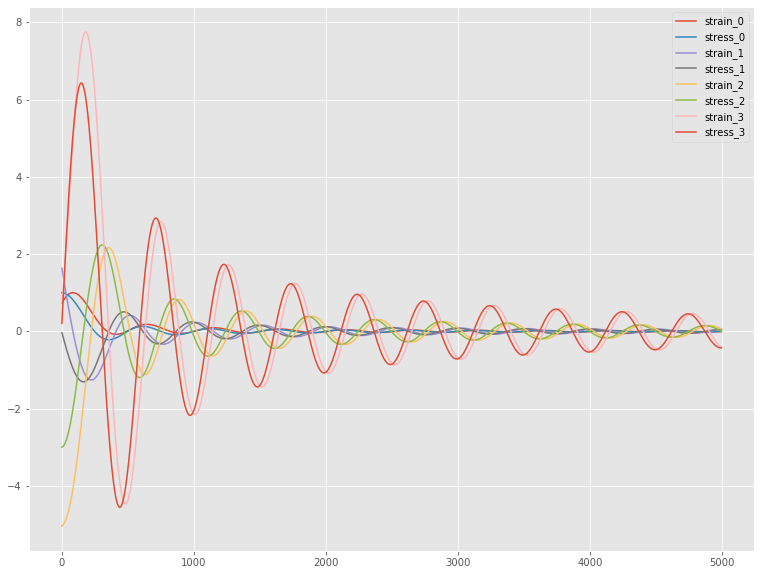

In [29]:
plt.figure(figsize=(13,10))
for i in range(strain_theta.shape[1]):
    plt.plot(strain_theta[diff_order:-diff_order, i], label='strain_'+str(i))
    plt.plot(stress_theta[diff_order:-diff_order, i], label='stress_'+str(i))

plt.legend()

In [30]:
#Calculate Averages
theta = np.concatenate((strain_theta, stress_theta), axis=1)
av_derivs = np.mean(abs(theta[diff_order:-diff_order, :]), axis=0)
av_derivs

array([0.07080983, 0.14101265, 0.42964385, 1.07501292, 0.05922379,
       0.13846639, 0.36240549, 0.99387074])

## Looping omega

In [10]:
omega_values = np.linspace(0.05, 3, 51)

In [11]:
Amp = 7
input_type = 'Strain'

E = [1, 1, 1]
eta = [2.5, 0.5]
diff_order = len(eta) + 1

In [12]:
av_derivs = np.empty((0, 2*(diff_order+1)))
for omega in omega_values:
    print(omega)
    input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
    d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
    
    time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)
    
    strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)
    
    # 'normalising'
    strain_sf = 1/np.max(abs(strain_array))
    stress_sf = 1/np.max(abs(stress_array))
    scaled_strain_array = strain_array*strain_sf
    scaled_stress_array = stress_array*stress_sf
    
    strain_theta = VE_datagen.num_derivs(scaled_strain_array, time_array, diff_order)
    stress_theta = VE_datagen.num_derivs(scaled_stress_array, time_array, diff_order)
    
    theta = np.concatenate((strain_theta, stress_theta), axis=1)
    av_derivs_single_omega = np.mean(abs(theta[diff_order:-diff_order, :]), axis=0).reshape(1, -1)
    
    av_derivs = np.concatenate((av_derivs, av_derivs_single_omega), axis=0)

0.05
0.10900000000000001
0.168
0.22700000000000004
0.28600000000000003
0.34500000000000003
0.404
0.463
0.522
0.5810000000000001
0.6400000000000001
0.6990000000000001
0.7580000000000001
0.8170000000000001
0.8760000000000001
0.935
0.9940000000000001
1.0530000000000002
1.112
1.171
1.2300000000000002
1.2890000000000001
1.348
1.407
1.4660000000000002
1.5250000000000001
1.584
1.6430000000000002
1.7020000000000002
1.7610000000000001
1.82
1.8790000000000002
1.9380000000000002
1.997
2.056
2.1149999999999998
2.174
2.233
2.292
2.351
2.41
2.469
2.528
2.587
2.646
2.705
2.764
2.823
2.882
2.941
3.0


### Plotting

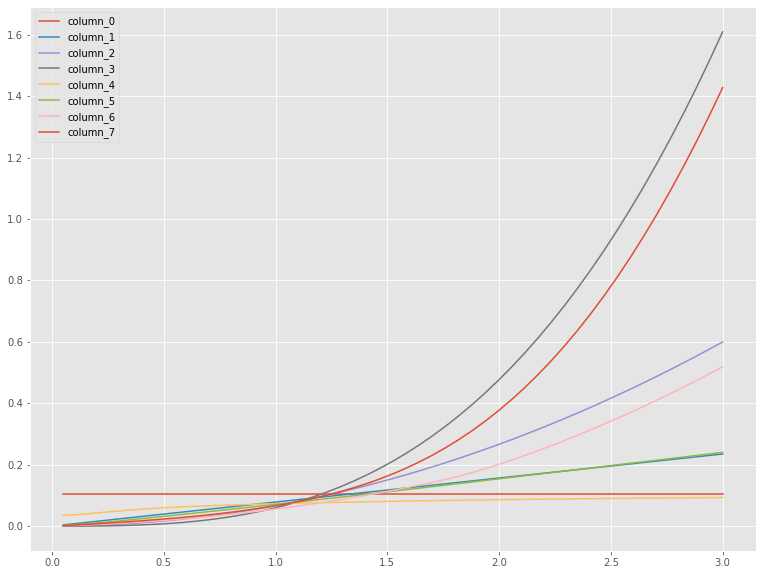

In [13]:
plt.figure(figsize=(13,10))
for i in range(av_derivs.shape[1]):
    plt.plot(omega_values, av_derivs[:, i], label='column_'+str(i))

plt.legend()

## Finding lowest disparity

In [14]:
disparity = np.std(av_derivs, axis=1)

### Plotting

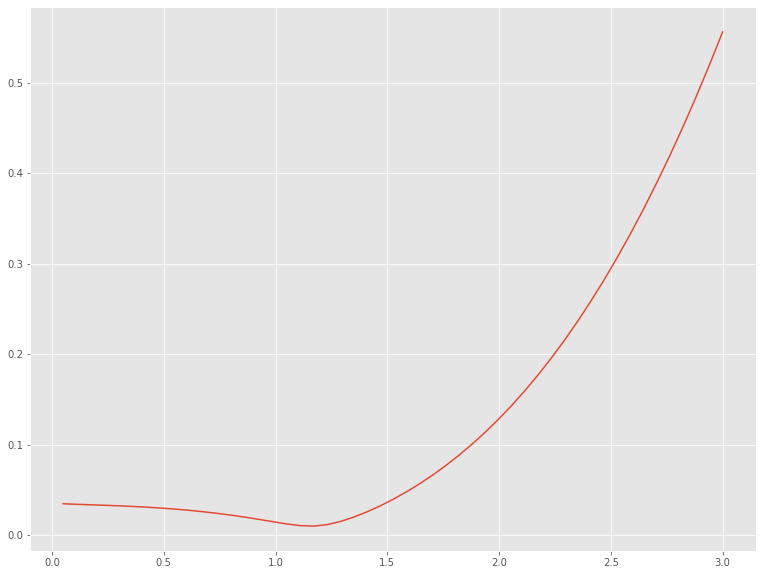

In [15]:
plt.figure(figsize=(13,10))
plt.plot(omega_values, disparity)

#### Optimum

In [16]:
best_omega_index = np.argmin(disparity)
best_omega = omega_values[best_omega_index]
best_omega

1.171